# Chapter 5 Exercises

In [39]:
import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Conceptual

### 2.h)
We will now investigate numerically the probability that a bootstrap sample of size $n = 100$ **contains** the $j$th observation. Here $j = 4$. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.

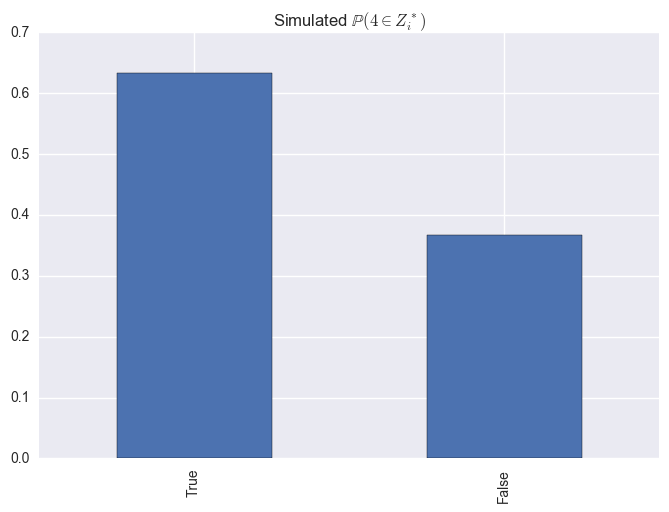

In [150]:
ntimes = 10000
store = pd.Series([4 in choice(range(1,101), size=100, replace=True) for _ in range(ntimes)])
store_freq = pd.value_counts(store, normalize=True)
store_freq.plot(kind="bar")
plt.title(r"Simulated $\mathbb{P}(4 \in Z_i^*)$")
plt.show()

In [149]:
print("P(4 in Sample [Simulation])  = {:.4f}".format(store.mean()))
print("P(4 in Sample [Theoretical]) = {:.4f}".format(1 - (1 - 1/100)**100))

P(4 in Sample [Simulation])  = 0.6348
P(4 in Sample [Theoretical]) = 0.6340


**Comment on the results obtained.**

The simulation yielded a pretty similar result as the theoretical. That is
$$
    \mathbb{P}(i \in Z_n^*) = 1 - \left(1 - \frac{1}{n}\right)^n
$$


Evidently, 
$$
    \mathbb{P}(i \in Z_n^*) \xrightarrow[n\rightarrow\infty]{} 1 - e^{-1}
$$

### Implementing the Bootstrap

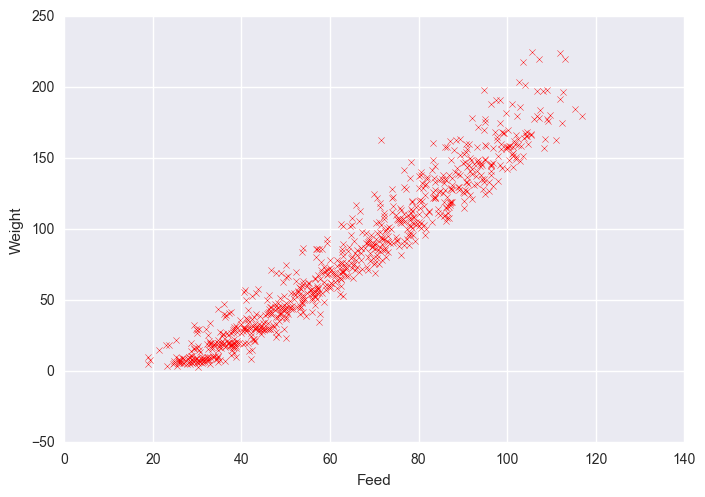

In [281]:
from pydataset import data
pig = data("dietox")[["Weight", "Feed", "Pig"]]
plt.scatter(pig.Weight, pig.Feed, color="red", marker="x")
plt.ylabel("Weight")
plt.xlabel("Feed")
plt.show()